In [1]:
import numpy as np
import pandas as pd
import pandas_ta
# import ta
import yfinance as yf
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import datetime as dt

import warnings
warnings.filterwarnings('ignore')

from numba import njit

%config InlineBackend.figure_format = 'retina'

In [ ]:
@njit
def ptfMeanVar(weights, avgReturns, covMatrix):
    """
    weights: vector of weights
    avgReturns: vector of mean returns of the returns of the assets
    covMatrix: covariance matrix of the returns
    """
    # returns mean and variance (normalised) of a given portfolio
    returns = np.sum(avgReturns*weights) * 252.
    std = np.sqrt(np.dot(weights.T, np.dot(covMatrix, weights))) * np.sqrt(252.)
    return std, returns

@njit
def randomPtf(nb_stocks, nbPtf, avgReturns, covMatrix, r): # Generate random portfolios
    """
    nb_stocks: specify a number of stocks in the portfolio
    nbPtf: specify a number of portfolios to be generated
    avgReturns: vector of mean returns of the returns of the assets
    covMatrix: covariance matrix of the returns
    r: target return (to compute the Sharpe ratio)
    """
    output = np.zeros((3,nbPtf))
    # weights_list = []
    all_weights = np.zeros((nbPtf, nb_stocks))
    for i in range(nbPtf):
        weights = np.random.random(nb_stocks)
        weights /= np.sum(weights) # make sure weights sum up to 1
        # weights_list.append(weights)
        all_weights[i] = weights
        std, returns = ptfMeanVar(weights, avgReturns, covMatrix)
        output[:,i] = std, returns, (returns - r) / std # the third quantity is the Sharpe ratio
    return output, all_weights
     # for each i, all_weights[i] is the vector of weights (positive and summing up to one) of the components of portfolio[i]
     # for each i, output[i] returns (standard deviation, returns, Sharpe ratio) of portfolio[i]

In [ ]:
def plotMarkowitz(df, avgReturns, covMatrix, nbPtf, r):
    """
    Create and plot the Markowitz frontier
    """
    nbStocks = len(df.columns)
    results, weights = randomPtf(nbStocks, nbPtf, avgReturns, covMatrix, r)
    
    max_sharpe_idx = np.argmax(results[2]) ## ID of the largest Sharpe ratio
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    maxSharpeAlloc = pd.DataFrame(100.*weights[max_sharpe_idx],index=df.columns,columns=['allocation']).T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    minSharpeAlloc = pd.DataFrame(100.*weights[min_vol_idx],index=df.columns,columns=['allocation']).T
    
    plt.figure(figsize=(10, 7))
    plt.tight_layout()
    plt.scatter(results[0,:],results[1,:],c=results[2,:], cmap='YlGnBu', marker='x', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='x',color='r',s=50, label='Max Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='o',color='k',s=50, alpha=0.8, label='Min volatility')
    
    def get_cmap(n, name='hsv'):
        return plt.cm.get_cmap(name, n)

    cmap = get_cmap(nbStocks)
    for i in range(nbStocks): ## Plot each individual stock
        # myVar = np.sqrt(covMatrix.values[i,i]*252.)
        myVar = np.sqrt(covMatrix[i,i]*252.)
        # myRet = avgReturns.values[i]*252.
        myRet = avgReturns[i]*252.
        plt.scatter(myVar,myRet,s=50, c=cmap(i), label=df.columns.values[i])

    plt.xlabel('Volatility')
    plt.ylabel('Returns')
    plt.legend(loc='best', prop={'size': 12}, ncols=nbStocks//2)
    plt.show()
    
    print("-"*30)
    print("Max Sharpe Ratio Portfolio")
    print("Return, vol, Sharpe:", round(rp,2), round(sdp,2), round((rp - r) / sdp,2))
    print(maxSharpeAlloc.round(2))
    print("-"*30)
    print("Min Volatility Portfolio")
    print("Return, vol, Sharpe:", round(rp_min,2), round(sdp_min,2), round((rp_min - r) / sdp_min,2))
    print(minSharpeAlloc.round(2))
    print("-"*30)
    
    return maxSharpeAlloc

In [5]:
symbols_list = ['AAPL', 'NVDA', 'BLK', 'TLSA', 'META', 'AMD', 'MSFT', 'GOOGL', 'TSM']

In [6]:
end_date = dt.datetime.today()
start_date = pd.to_datetime(end_date) - pd.DateOffset(365*5)

In [7]:
df = yf.download(symbols_list,
                 start=start_date,
                 end=end_date, threads=True).stack()
df.index.names = ['date', 'ticker']
df.columns = df.columns.str.lower()
df.columns.name = None

[*********************100%***********************]  9 of 9 completed


In [8]:
rets = df.close.unstack().pct_change().dropna()

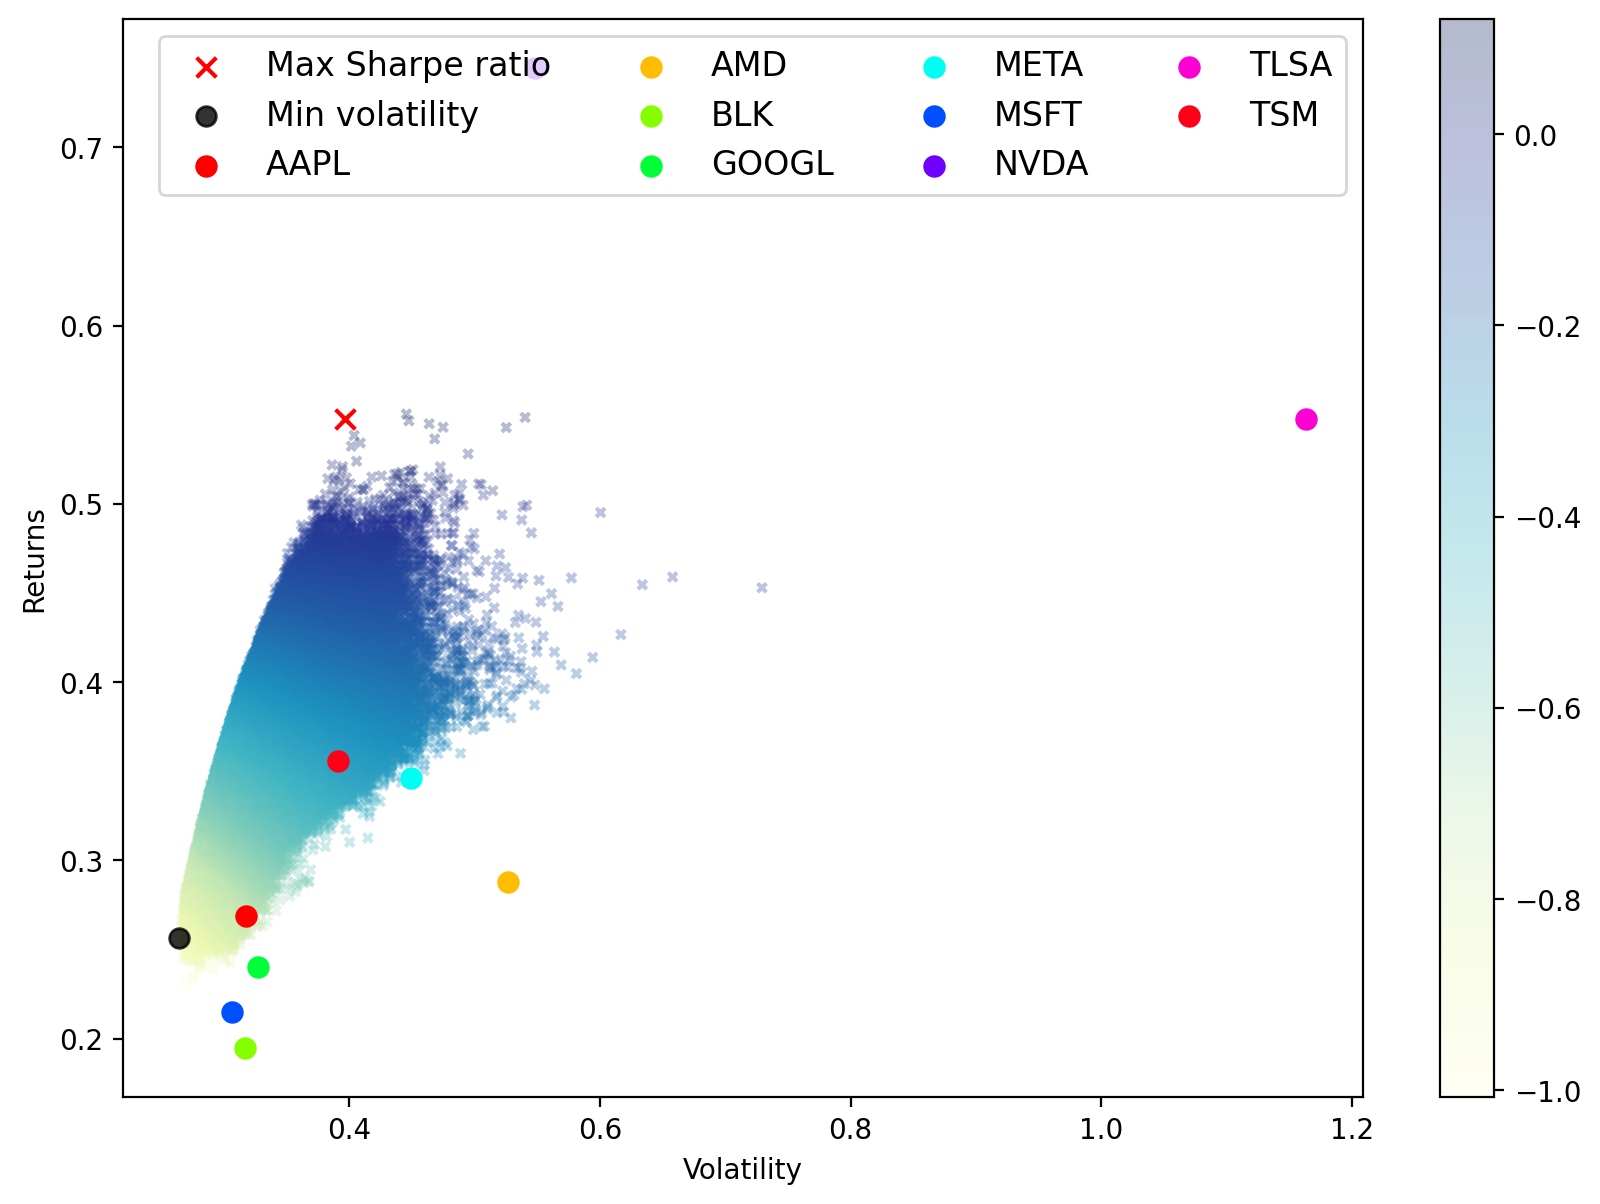

------------------------------
Max Sharpe Ratio Portfolio
Return, vol, Sharpe: 0.55 0.4 0.12
ticker       AAPL   AMD    BLK  GOOGL  META  MSFT   NVDA  TLSA   TSM
allocation  10.85  0.58  11.34   0.64  7.11  2.88  54.21  7.71  4.68
------------------------------
Min Volatility Portfolio
Return, vol, Sharpe: 0.26 0.26 -0.92
ticker       AAPL   AMD    BLK  GOOGL  META   MSFT  NVDA  TLSA    TSM
allocation  13.61  0.03  25.51  19.87  0.37  24.15  0.48  4.65  11.33
------------------------------


In [9]:
avgReturns, covMatrix = rets.mean().values, rets.cov().values

nbPtf = 1_000_000 # number of runs
r = 0.5 # interest rate
max_sharp = plotMarkowitz(rets, avgReturns, covMatrix, nbPtf, r)

In [10]:
max_sharp.round(2)

ticker,AAPL,AMD,BLK,GOOGL,META,MSFT,NVDA,TLSA,TSM
allocation,10.85,0.58,11.34,0.64,7.11,2.88,54.21,7.71,4.68
